# Forecasting Daily Load Values in Tetouan

#### Goal
Forecast the daily electricity consumption in Tetouan, Morocco.

The data is a text file consisting of comma separated values, and can be found from UC Irvine's [Machine Learning Repository](https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city).

Each record contains 6 features and three targets:
 1. [feature] Datetime
 2. [feature] Temperature
 3. [feature] Humidity
 4. [feature] Wind Speed
 5. [feature] General Diffuse Flows
 6. [feature] Diffuse Flows
 7. [target] Zone 1 Power Consumption
 8. [target] Zone 2 Power Consumption
 9. [target] Zone 3 Power Consumption

There is a total of 52416 records. This represents 1 entire year of data, where the load values are sampled in 10 minute intervals. It is worth noting that Tetouan is a city in Morocco, so any modifications of the `DateTime` feature should take into account that Muslim countries do not have the same Sunda/Monday paradigm that Christian countries do, and that there is a different holiday schedule.

Based on an entry in the [CoderzColumn](https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-lstm-networks-for-time-series-regression-tasks) Data Science / AI blog

#### Methodology

The forecasting approach will consist of applying a **Many-to-One Long-Short Term Memory (LSTM)** neural network, as implemented in the PyTorch module. The `many` refers to the fact that several features will be used when constructing the prediction of a `one` value, which in this case will be `Zone 1 Power Consumption`.

#### Observations

The LSTM block performs well detecting and forecasting the periodicity of the data. The performance on forecasting the absolute magnitures at the peaks and troughs is uniformly bad, however. This approach would not work for common load profile problems such as forecasting monthly peaks. In particular, the forecasted magnitudes in the trough regions are extremely bad, as they do not even capture the right curvature.

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import gc
from torch.optim import Adam
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# ---------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3070 Laptop GPU


In [8]:
df_orig = pd.read_csv("tetuan_power.csv")
df_orig.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTime                   52416 non-null  object 
 1   Temperature                52416 non-null  float64
 2   Humidity                   52416 non-null  float64
 3   Wind Speed                 52416 non-null  float64
 4   general diffuse flows      52416 non-null  float64
 5   diffuse flows              52416 non-null  float64
 6   Zone 1 Power Consumption   52416 non-null  float64
 7   Zone 2  Power Consumption  52416 non-null  float64
 8   Zone 3  Power Consumption  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


The main thing to note here is that there are no null entries in any of the data frame cells. Convert the `DateTime` column into the right format, and set it as the data frame index

In [10]:
df_orig["DateTime"] = pd.to_datetime(df_orig["DateTime"])
df_orig = df_orig.set_index('DateTime')

Plotting the entire range of the `Zone 1 Power Consumption` reveals that the summer months are highest in demand.

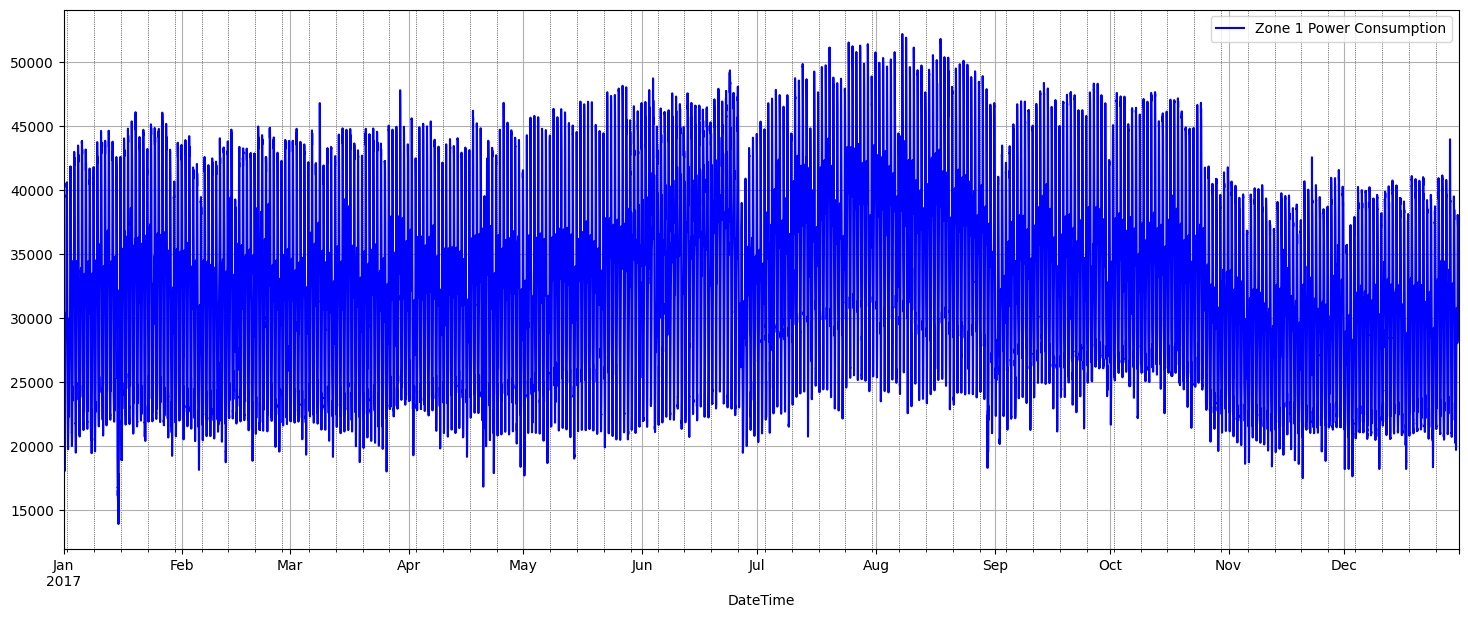

In [18]:
df_orig.loc["2017-1":"2017-12"].plot(
    y="Zone 1 Power Consumption",
    figsize=(18, 7),
    color="blue",
    grid=True
)
plt.grid(
    which="minor", 
    linestyle=":", 
    linewidth="0.5", 
    color="black"
)

The closer look into a daily load shows the expected peak in the late afternoon, along with the characteristic shape produced by participation in demand reduction programs.

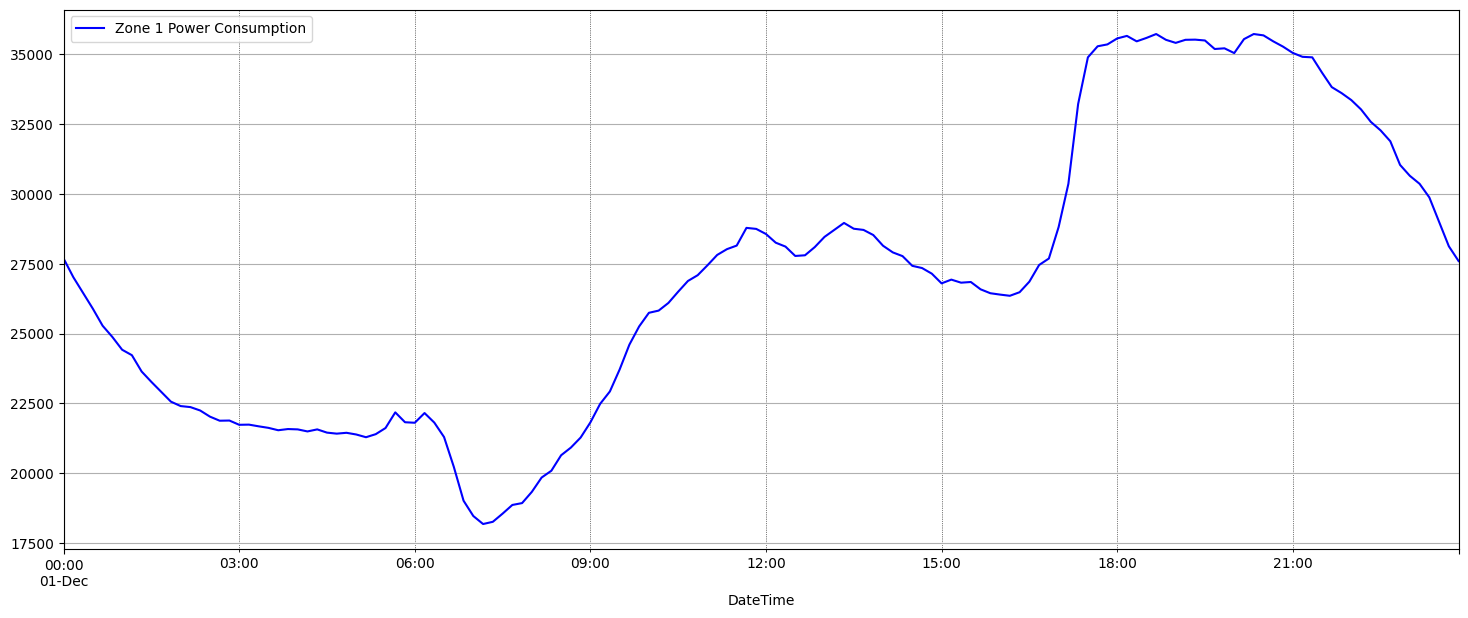

In [14]:
df_orig.loc["2017-12-1"].plot(
    y="Zone 1 Power Consumption", 
    figsize=(18, 7), 
    color="blue", 
    grid=True
)
plt.grid(
    which="minor", 
    linestyle=":", 
    linewidth="0.5", 
    color="black"
)

Set up the lists of features & forecasting target

In [ ]:
# these are the forecasting features
df_feat = df_orig[[
        'Temperature',
        'Humidity',
        'Wind Speed',
        'general diffuse flows',
        'diffuse flows'
    ]
].values
# this is the forecasting target
df_trgt = df_orig[
    'Zone 1 Power Consumption'
].values

In [ ]:
# n_features = df_feat.shape[1]
lookback = 30 ## 5 hours lookback to make prediction
X_org = []
y_org = []
for i in range(0, df_feat.shape[0] - lookback, 1):
    X_org.append(df_feat[i:i+lookback])
    y_org.append(df_trgt[  i+lookback])
X_org = torch.tensor(np.array(X_org), dtype=torch.float32)
y_org = torch.tensor(np.array(y_org), dtype=torch.float32)

# X_train, y_train, X_test, y_test = X_organized[:50000], y_organized[:50000], X_organized[50000:], Y_organized[50000:]

tensor([[[6.5590e+00, 7.3800e+01, 8.3000e-02, 5.1000e-02, 1.1900e-01],
         [6.4140e+00, 7.4500e+01, 8.3000e-02, 7.0000e-02, 8.5000e-02],
         [6.3130e+00, 7.4500e+01, 8.0000e-02, 6.2000e-02, 1.0000e-01],
         ...,
         [5.3940e+00, 7.1900e+01, 8.1000e-02, 7.3000e-02, 1.0000e-01],
         [5.1560e+00, 7.4000e+01, 7.9000e-02, 6.2000e-02, 1.4800e-01],
         [5.1790e+00, 7.4200e+01, 8.3000e-02, 3.7000e-02, 1.3700e-01]],

        [[6.4140e+00, 7.4500e+01, 8.3000e-02, 7.0000e-02, 8.5000e-02],
         [6.3130e+00, 7.4500e+01, 8.0000e-02, 6.2000e-02, 1.0000e-01],
         [6.1210e+00, 7.5000e+01, 8.3000e-02, 9.1000e-02, 9.6000e-02],
         ...,
         [5.1560e+00, 7.4000e+01, 7.9000e-02, 6.2000e-02, 1.4800e-01],
         [5.1790e+00, 7.4200e+01, 8.3000e-02, 3.7000e-02, 1.3700e-01],
         [4.9340e+00, 7.2900e+01, 8.2000e-02, 5.5000e-02, 1.3400e-01]],

        [[6.3130e+00, 7.4500e+01, 8.0000e-02, 6.2000e-02, 1.0000e-01],
         [6.1210e+00, 7.5000e+01, 8.3000e-02,

z-score normalization:

In [ ]:
mean, std = Y_train.mean(), Y_train.std()

print("Mean : {:.2f}, Standard Deviation : {:.2f}".format(mean, std))

Y_train_scaled, Y_test_scaled = (Y_train - mean)/std , (Y_test-mean)/std

print(Y_train_scaled.min())
print(Y_train_scaled.max())
print(Y_test_scaled.min())
print(Y_test_scaled.max())

In [ ]:
import gc
del X, Y
gc.collect()

In [ ]:
train_dataset = TensorDataset(X_train, Y_train_scaled)
test_dataset  = TensorDataset(X_test,  Y_test_scaled)

train_loader = DataLoader(train_dataset, shuffle=False, batch_size=32)
test_loader  = DataLoader(test_dataset,  shuffle=False, batch_size=32)

In [ ]:
hidden_dim  = 128
n_layers    = 2

class LSTMRegressor(
        nn.Module
    ):
    def __init__(self):
        super(
            LSTMRegressor,
            self
        ).__init__()
        self.lstm = nn.LSTM(
            input_size  = n_features,
            hidden_size = hidden_dim,
            num_layers  = n_layers,
            batch_first = True
        )
        self.linear = nn.Linear(
            hidden_dim,
            1
        )
    def forward(self, X_batch):
        hidden, carry = torch.randn(
            n_layers,
            len(X_batch),
            hidden_dim
        ),
        torch.randn(
            n_layers,
            len(X_batch),
            hidden_dim
        )
        output, (hidden, carry) = self.lstm(X_batch, (hidden, carry))
        return self.linear(output[:,-1])

In [ ]:
lstm_regressor = LSTMRegressor()

In [ ]:
for layer in lstm_regressor.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

In [ ]:
def CalcValLoss(model, loss_fn, val_loader):
    with torch.no_grad():
        losses = []
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds.ravel(), Y)
            losses.append(loss.item())
        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds.ravel(), Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLoss(model, loss_fn, val_loader)

In [ ]:
epochs = 20
learning_rate = 1e-3

loss_fn = nn.MSELoss()
lstm_regressor = LSTMRegressor()
optimizer = Adam(lstm_regressor.parameters(), lr=learning_rate)

TrainModel(lstm_regressor, loss_fn, optimizer, train_loader, test_loader, epochs)

In [ ]:
test_preds = lstm_regressor(X_test) ## Make Predictions on test dataset
test_preds  = (test_preds*std) + mean

test_preds[:5]

In [ ]:
print(
    "Test  MSE : {:.2f}".format(mean_squared_error(test_preds.detach().numpy().squeeze(),Y_test.detach().numpy()))
)
print(
    "Test  R^2 Score : {:.2f}".format(r2_score(test_preds.detach().numpy().squeeze(), Y_test.detach().numpy()))
)

In [ ]:
data_df_final = data_df[50000:].copy()

data_df_final["Zone 1 Power Consumption Prediction"] = [None]*lookback + test_preds.detach().numpy().squeeze().tolist()

data_df_final.tail()

In [ ]:
data_df_final.plot(
    y=["Zone 1 Power Consumption", "Zone 1 Power Consumption Prediction"],
    figsize=(18,7)
)
plt.grid(
    which='minor',
    linestyle=':',
    linewidth='0.5',
    color='black'
);